In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

In [12]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH= download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_SPEECH1 = "/Users/amani/Desktop/My-voice-recording.wav"

def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

relationship between common audio features and torchaudio APIs to generate them.

![overview of audio features](https://download.pytorch.org/torchaudio/tutorial-assets/torchaudio_feature_extractions.png)

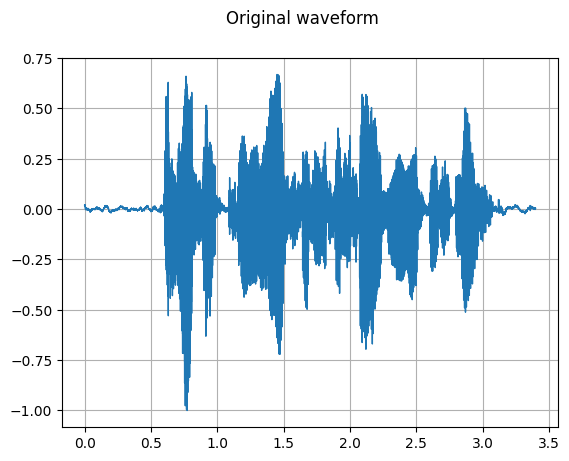

In [3]:
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform")
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

In [6]:
n_fft = 1024
win_length = None
hop_length = 512

# Define tranform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

In [23]:
# perform transform
spec = spectrogram(SPEECH_WAVEFORM)

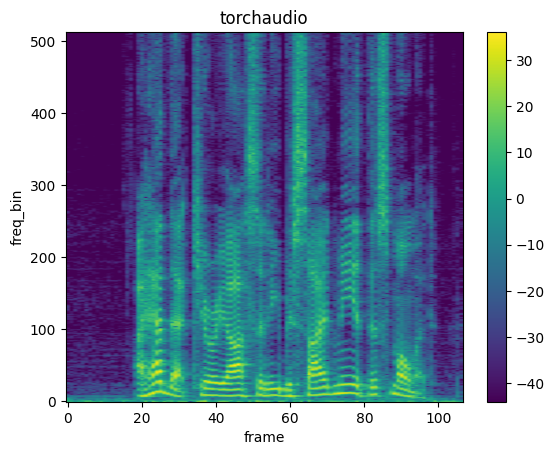

In [8]:
plot_spectrogram(spec[0], title="torchaudio")

recover a waveform from a spectrogram => use griffinLim

In [15]:
torch.random.manual_seed(0)

n_fft = 1024
win_length = None
hop_length = 512


spec = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
) ( SPEECH_WAVEFORM)

In [16]:
griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length
)

In [17]:
reconstructed_waveform = griffin_lim(spec)

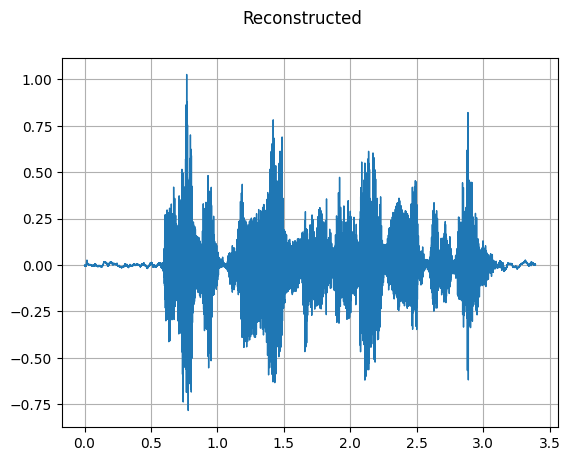

In [18]:
plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed")
Audio(reconstructed_waveform, rate=SAMPLE_RATE)

# mel filter bank 

torchaudio.functional.melscale_fbanks() generates the filter bank for converting frequency bins to mel-scale bins.

arrangement of badpass filters that split the input signal into a set of analysis signals, each one carrying a single frequency sub-band of the original signal.

In [19]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1 ),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate/2.0,
    sample_rate=sample_rate,
    norm='slaney',

)

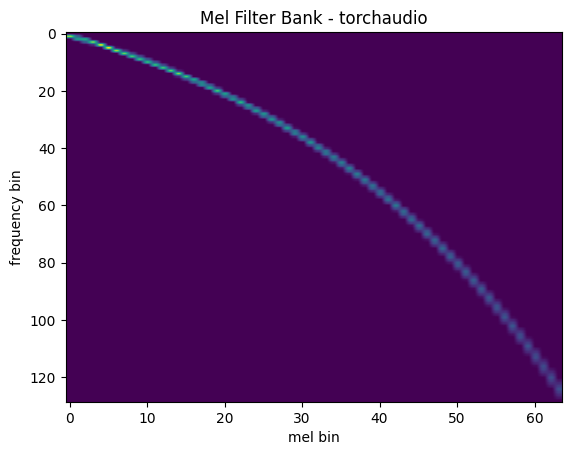

In [20]:
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

# mel spectrogram 

generating a mel-scale spectogram involves generating a spectrogram and performing mel-scale conversion.

In [22]:
n_fft = 1024 
win_length = None 
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft, 
    win_length=win_length, 
    hop_length=hop_length, 
    center=True,
    pad_mode="reflect", 
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels, 
    mel_scale="htk",
)

In [24]:
melspec = mel_spectrogram(SPEECH_WAVEFORM)

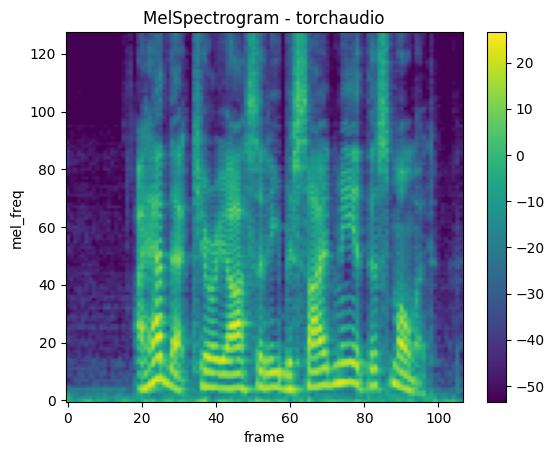

In [26]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel_freq")

In [27]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)

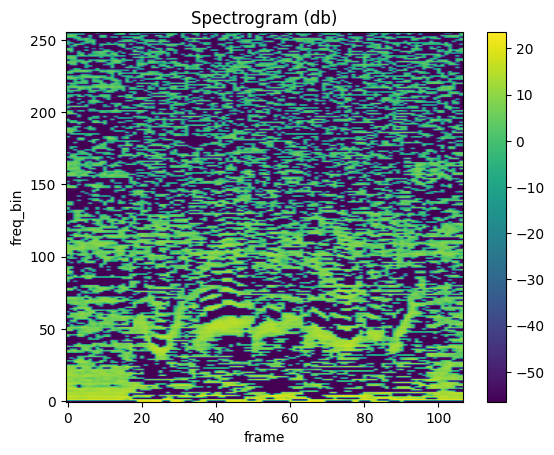

In [28]:
plot_spectrogram(mfcc[0])

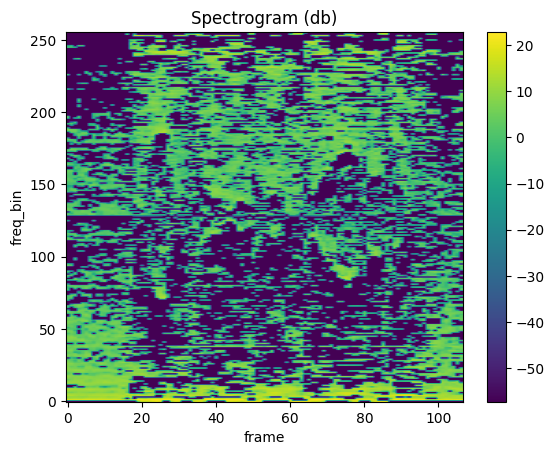

In [29]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(SPEECH_WAVEFORM)
plot_spectrogram(lfcc[0])

In [30]:
pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM, SAMPLE_RATE)

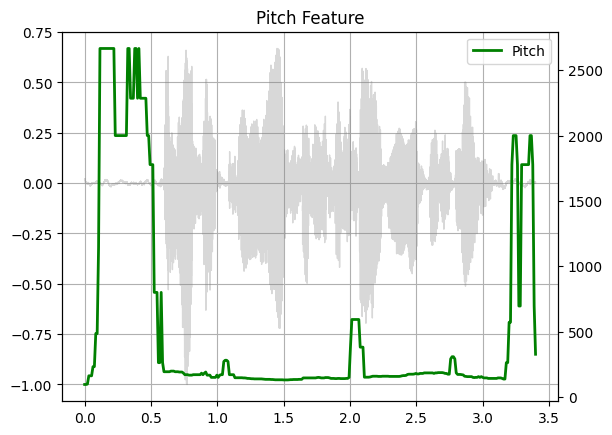

In [31]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)
    plt.show(block=False)


plot_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch)

# kaldi pitch (beta)

pitch detection mechanism tuned for automatic speech recognition 
( ASR ) applications.

torchaudio.functional.compute_kaldi_pitch().

pitch extraction algorithm tuned for automatic speech recognition.

In [32]:
pitch_feature = F.compute_kaldi_pitch(SPEECH_WAVEFORM, SAMPLE_RATE)
pitch, nfcc = pitch_feature[..., 0], pitch_feature[..., 1]

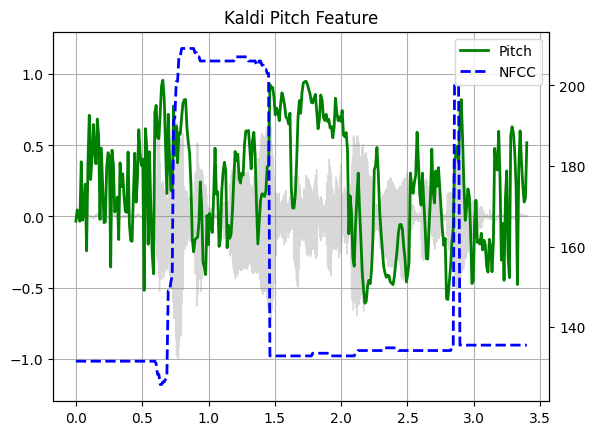

In [36]:
def plot_kaldi_pitch(waveform, sr, pitch, nfcc):
    _, axis = plt.subplots(1, 1)
    axis.set_title("Kaldi Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")
    axis.set_ylim((-1.3, 1.3))

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, nfcc.shape[1])
    ln2 = axis2.plot(time_axis, nfcc[0], linewidth=2, label="NFCC", color="blue", linestyle="--")

    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    axis.legend(lns, labels, loc=0)
    plt.show(block=False)


plot_kaldi_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch, nfcc)

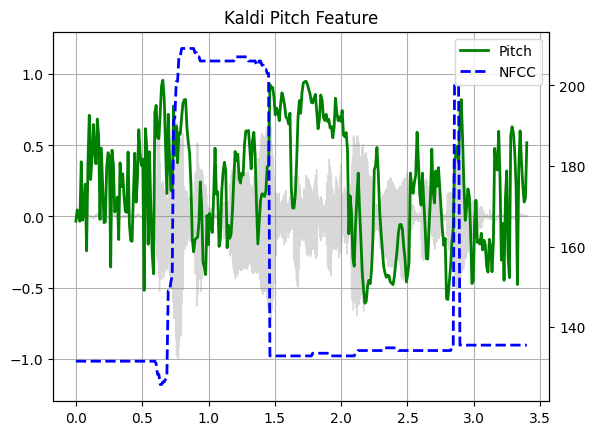

In [37]:
plot_kaldi_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch, nfcc)